# _Randomly Connected Neural Networks for Self-Supervised Monocular Depth Estimation_ Demo Notebook

## Imports

In [1]:
! pip install --upgrade pip
! pip install -r requirements.txt

In [2]:
from matplotlib import pyplot as plt

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import yaml

from loaders import CityScapesDataset

from model import RandomlyConnectedModel

import train
from train.loss import MonodepthLoss

## Setup

### CUDA

In [3]:
device = torch.device("cuda") \
    if torch.cuda.is_available() \
        else torch.device("cpu")

print(device)

cuda


### Config file

In [4]:
with open("config.yml") as f:
    model_config = yaml.load(f, Loader=yaml.Loader)

encoder_config = model_config["encoder"]
decoder_config = model_config["decoder"]

### Hyperparameters

In [5]:
# Dataset parameters
batch_size = 8
validation_samples = 1000
numberof_workers = 8

# Training parameters
numberof_epochs = 50
learning_rate = 1e-4

## Dataset

### Transforms

In [6]:
train_transform = transforms.Compose([
    train.transforms.ResizeImage((256, 512)),
    train.transforms.RandomFlip(0.5),
    train.transforms.ToTensor(),
    train.transforms.RandomAugment(0.5, gamma=(0.8, 1.2),
                                   brightness=(0.5, 2.0),
                                   colour=(0.8, 1.2))
])

val_transform = transforms.Compose([
    train.transforms.ResizeImage((256, 512)),
    train.transforms.ToTensor()
])

### CityScapes

In [7]:
train_dataset = CityScapesDataset("../datasets/cityscapes/", "train",
                                  train_transform)
                                  
val_dataset = CityScapesDataset("../datasets/cityscapes/", "val",
                                val_transform, validation_samples)

print(f"Dataset size:"
      f"\n\tTrain: {len(train_dataset):,} images."
      f"\n\tTest: {len(val_dataset):,} images.")

Dataset size:
	Train: 2,975 images.
	Test: 500 images.


### Loaders

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=numberof_workers)

val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=numberof_workers)

## Model

### Initialisation

In [9]:
# Temporary solution until config code is set up
#model = RandomlyConnectedModel(nodes=5, seed=42).to(device)
model = RandomlyConnectedModel(load_graph="graphs/nodes_5_seed_42").to(device)
#model = RandomlyConnectedModel(encoder_config, decoder_config).to(device)

numberof_parameters = sum(p.numel() for p in model.parameters())
print(f"Model has {numberof_parameters:,} learnable parameters.")
print(f"Using CUDA? {next(model.parameters()).is_cuda}")

Model has 22,818,044 learnable parameters.
Using CUDA? True


### Train

In [13]:
train.train_model(model, train_loader, numberof_epochs, learning_rate,
                  val_loader=val_loader, evaluate_every=5, 
                  save_path="trained/", save_every=10,
                  save_comparison_to="results/",
                  device=device)

Epoch #1:   0%|          | 0/372 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Evaluation: 100%|██████████| 63/63 [00:24<00:00,  2.56batch/s, loss=2.64e+4]


Training completed.


([66402.29748928931,
  41627.316490255376,
  39696.121860299056,
  37402.46997332829,
  35464.77601016465,
  35011.57428700437,
  34727.15385584677,
  34608.031832787296,
  34113.00109206989,
  33963.15532594086,
  33623.075772849465,
  33493.31791834677,
  33033.10630880376,
  32863.84428553427,
  32664.50981812836,
  31675.11627919187,
  31500.501632854503,
  31415.121230258737,
  31750.71035996304,
  31887.32663652974,
  31624.80859375,
  32096.0906890541,
  31990.304304225472,
  32168.729061659946,
  32930.87814757645,
  32035.732894405242,
  32607.57461777554,
  33114.33875168011,
  35567.25817477318,
  34345.18028078797,
  34297.5867828041,
  34382.09145560316,
  34871.46156228999,
  34075.835774739586,
  34431.44309160786,
  34196.459199638775,
  33581.54747878864,
  34262.77872983871,
  33347.04185567876,
  33355.20422757057,
  34052.98114604335,
  33388.29933215726,
  33489.316356371804,
  33670.06030535954,
  33367.75281418011,
  33009.362693212366,
  33553.76801915323,
  338

### Evaluate

In [14]:
model.eval()

loss_function = MonodepthLoss().to(device)

train.evaluate_model(model, val_loader, loss_function,
                     save_comparison_to="results/",
                     device=device)

Evaluation: 100%|██████████| 63/63 [00:24<00:00,  2.60batch/s, loss=2.62e+4]


26154.499069940477

### Results

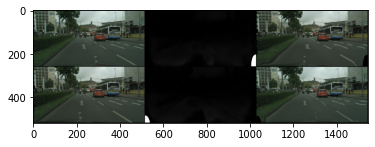

In [16]:
image = Image.open("results/final.png")
plt.imshow(image)